# OWCS FaceIT Match Data dataset - Export a Machine Learning Model
In this notebook, we will perform exploratory data analysis (EDA), build a preprocessing pipelines for numerical and categorical features, train and evaluate the model and export the model.

This dataset contains cleaned and aggregated match data from the Overwatch Champions Series (OWCS) played on FaceIT servers across the EMEA and NA regions. The data covers Stages 1–2 and part of Stage 3 (2025), extracted via the official FaceIT API and processed for analytics and machine learning purposes. The dataset is sourced from Kaggle: https://www.kaggle.com/datasets/stlze8/owcs-faceit-match-data-emea-and-na-2025

## Setup

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('data.csv')

## Basic info and statistics

In [3]:
# Display first few rows to understand the structure
data.head()

,match_id,match_date,round_num,map_name,hero_bans,team,player,Damage Dealt,Damage Mitigated/Eliminations,Environmental Kills/10m,...,Damage Mitigated/10m,Eliminations,Solo Kills/Final Blows Ratio,Final Blows/10m,Healing Done/10m,Role,map_type,region,phase,stage
0,EMEA_S1_RR_W4_D2_M1,2025-02-22T18:51:05,1,Samoa,Juno,Team Peps,Xzodyal,7187,71.46,0.0,...,1004.32,13,0.12,8.65,0.00,Damage,Control,EMEA,Round Robin,S1
1,EMEA_S1_RR_W4_D2_M1,2025-02-22T18:51:05,1,Samoa,Juno,Team Peps,Ken,6619,100.00,0.0,...,1297.30,12,0.00,5.41,137.30,Damage,Control,EMEA,Round Robin,S1
2,EMEA_S1_RR_W4_D2_M1,2025-02-22T18:51:05,1,Samoa,Juno,Team Peps,Eisgnom,10775,212.65,0.0,...,5287.57,23,0.00,6.49,1375.14,Tank,Control,EMEA,Round Robin,S1
3,EMEA_S1_RR_W4_D2_M1,2025-02-22T18:51:05,1,Samoa,Juno,Team Peps,Xeriongdh,4575,0.00,0.0,...,0.00,13,0.00,5.41,9901.62,Support,Control,EMEA,Round Robin,S1
4,EMEA_S1_RR_W4_D2_M1,2025-02-22T18:51:05,1,Samoa,Juno,Team Peps,Fdgod,4417,75.47,0.0,...,1223.78,15,0.00,3.24,5347.03,Support,Control,EMEA,Round Robin,S1


In [4]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 56 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   match_id                                     6110 non-null   str    
 1   match_date                                   6110 non-null   str    
 2   round_num                                    6110 non-null   int64  
 3   map_name                                     6110 non-null   str    
 4   hero_bans                                    6110 non-null   str    
 5   team                                         6110 non-null   str    
 6   player                                       6110 non-null   str    
 7   Damage Dealt                                 6110 non-null   int64  
 8   Damage Mitigated/Eliminations                6110 non-null   float64
 9   Environmental Kills/10m                      6110 non-null   float64
 10  Damage as p

## Exploratory Data Analysis (EDA)

Before we build a predictive model, we’ll explore:
- The target label distribution (`Result`) to see if the dataset is imbalanced.
- Missing values (notably `region`).
- Distributions of core performance metrics.
- Which numeric player stats appear most correlated with winning (as a first-pass signal for feature selection).

> Note: at this stage the dataset is **player × map(round)** rows. Later we will transform it into **matchup rows** by aggregating 5 players into a team and taking **TeamA − TeamB** differentials.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Parse dates once for later chronological splitting
data['match_date'] = pd.to_datetime(data['match_date'], errors='coerce')

# Quick sanity checks
print('Rows:', len(data))
print('Unique matches (match_id):', data['match_id'].nunique())
print('Unique players:', data['player'].nunique())
print('Null match_date:', data['match_date'].isna().sum())

display(data[['match_id','match_date','round_num','map_type','region','phase','stage']].head())

Rows: 6110
Unique matches (match_id): 171
Unique players: 150
Null match_date: 0


,match_id,match_date,round_num,map_type,region,phase,stage
0,EMEA_S1_RR_W4_D2_M1,2025-02-22 18:51:05,1,Control,EMEA,Round Robin,S1
1,EMEA_S1_RR_W4_D2_M1,2025-02-22 18:51:05,1,Control,EMEA,Round Robin,S1
2,EMEA_S1_RR_W4_D2_M1,2025-02-22 18:51:05,1,Control,EMEA,Round Robin,S1
3,EMEA_S1_RR_W4_D2_M1,2025-02-22 18:51:05,1,Control,EMEA,Round Robin,S1
4,EMEA_S1_RR_W4_D2_M1,2025-02-22 18:51:05,1,Control,EMEA,Round Robin,S1


### Target distribution (class balance)

`Result` is the binary label (1 = win for the row’s team, 0 = loss). Because we’ll later reshape the data into *two-team matchups*, it’s still useful to inspect balance at the player-row level first.

Result counts:


Result
0    3050
1    3050
2      10
Name: count, dtype: int64


Result proportions:


Result
0    0.499182
1    0.499182
2    0.001637
Name: proportion, dtype: float64

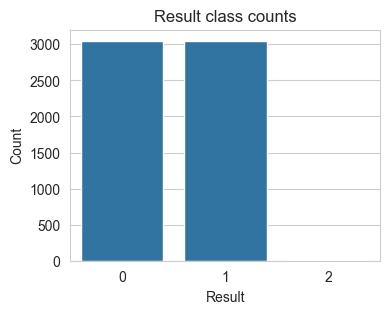

In [6]:
result_counts = data['Result'].value_counts().sort_index()
result_props = data['Result'].value_counts(normalize=True).sort_index()

print('Result counts:')
display(result_counts)
print('\nResult proportions:')
display(result_props)

plt.figure(figsize=(4,3))
sns.barplot(x=result_counts.index.astype(str), y=result_counts.values)
plt.title('Result class counts')
plt.xlabel('Result')
plt.ylabel('Count')
plt.show()

### Missing values

We’ll check missingness because:
- Missing categorical values (e.g., `region`) need explicit handling (fill + one-hot).
- Missing numeric values (if any) require imputation or row filtering.

Columns with missing values (fraction):


region                 0.486088
Environmental Kills    0.000164
Time Played            0.000164
Objective Time         0.000164
Final Blows            0.000164
Multi Kills            0.000164
Solo Kills             0.000164
dtype: float64

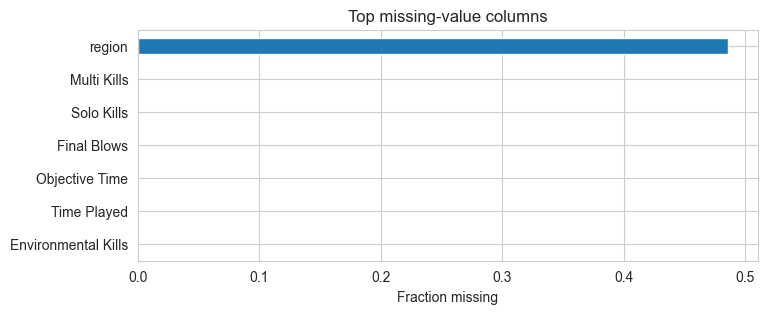

In [7]:
missing = data.isna().mean().sort_values(ascending=False)
missing = missing[missing > 0]

print('Columns with missing values (fraction):')
display(missing)

plt.figure(figsize=(8,3))
missing.head(15).sort_values().plot(kind='barh')
plt.title('Top missing-value columns')
plt.xlabel('Fraction missing')
plt.show()

### Numeric vs categorical columns

The dataset contains:
- **Metadata / categorical**: e.g. `map_type`, `phase`, `stage`, `Role`, `hero_bans`
- **Numeric player stats**: rates per 10 minutes, ratios, totals

We’ll split these because preprocessing differs (scaling for numeric, one-hot for categorical).

In [8]:
target_col = 'Result'

id_like = {'match_id','match_date','round_num','map_name','hero_bans','team','player'}
cat_like = {'Role','map_type','region','phase','stage'}

categorical_cols = sorted(list((data.columns.intersection(cat_like)).tolist()))

numeric_cols = [c for c in data.columns if c not in id_like and c not in cat_like and c != target_col]

print('Categorical columns:', categorical_cols)
print('Numeric columns:', len(numeric_cols))
print('Example numeric columns:', numeric_cols[:10])

Categorical columns: ['Role', 'map_type', 'phase', 'region', 'stage']
Numeric columns: 43
Example numeric columns: ['Damage Dealt', 'Damage Mitigated/Eliminations', 'Environmental Kills/10m', 'Damage as percent of total output', 'Time Played', 'Solo Kills/Deaths Ratio', 'Healing Done/Eliminations', 'Environmental Kills', 'Damage Mitigated/Deaths', 'Damage Mitigated as percent of total output']


### Distributions of core performance metrics

We’ll look at several high-level gameplay stats that (intuitively) should relate to winning:
- Damage output (`Damage Dealt/10m`)
- Fight impact (`Eliminations/10m`, `Final Blows/10m`)
- Survivability (`Deaths/10m`, `K/D Ratio`)
- Resource contribution (`Healing Done/10m`, `Damage Mitigated/10m`)
- Objective pressure (`Objective Time/10m`)

These are *player-level* distributions; later we’ll aggregate 5 players into team-level sums.

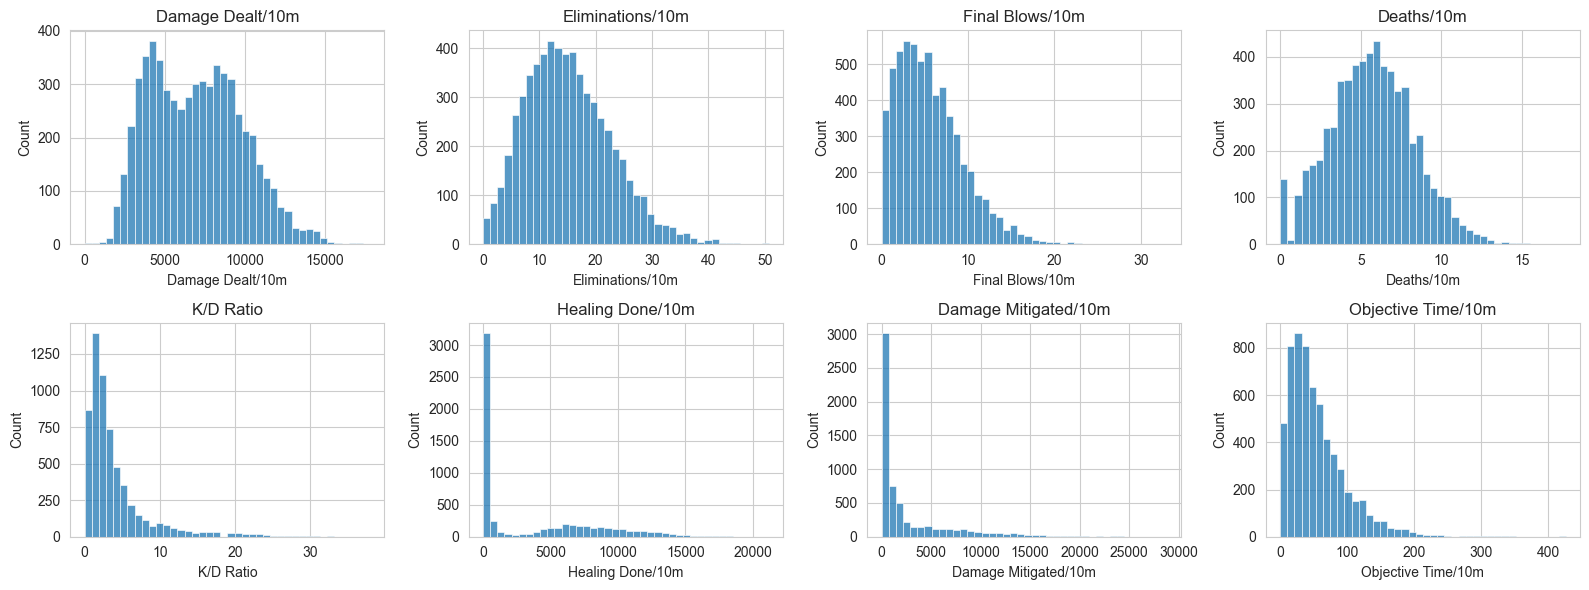

In [9]:
core_stats = [
    'Damage Dealt/10m',
    'Eliminations/10m',
    'Final Blows/10m',
    'Deaths/10m',
    'K/D Ratio',
    'Healing Done/10m',
    'Damage Mitigated/10m',
    'Objective Time/10m',
]

available_core = [c for c in core_stats if c in data.columns]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
axes = axes.ravel()

for ax, col in zip(axes, available_core):
    sns.histplot(data[col].replace([np.inf, -np.inf], np.nan).dropna(), bins=40, kde=False, ax=ax)
    ax.set_title(col)

for ax in axes[len(available_core):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

### Correlation with `Result` (player-row level)

This is a quick, imperfect signal:
- It’s computed on **player rows**, not matchups.
- Some columns are mathematically related (ratios derived from other stats).

Still, it helps shortlist candidate stats to aggregate later.

Top 15 absolute correlations with Result (player-row level):


Deaths/10m                              -0.619370
Eliminations/10m                         0.595160
(Eliminations + Assists)/Deaths          0.520242
K/D Ratio                                0.516487
Eliminations                             0.480139
Deaths                                  -0.472157
Final Blows/10m                          0.408164
Damage Dealt/Eliminations               -0.397485
Final Blows                              0.339692
Damage Dealt/(Eliminations + Assists)   -0.330694
Assists/10m                              0.276311
Assists                                  0.232991
Healing Done/Deaths                      0.200796
Solo Kills/Deaths Ratio                  0.198643
Healing Done/Eliminations               -0.191139
Name: Result, dtype: float64

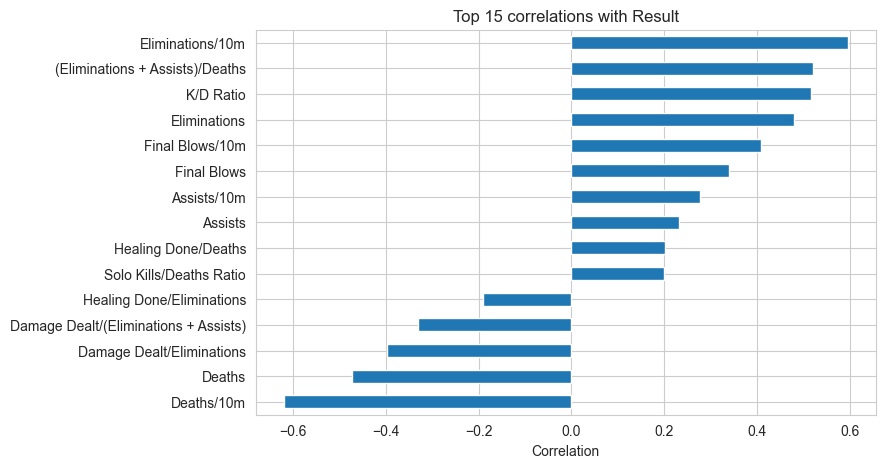

In [10]:
numeric_for_corr = data[numeric_cols + [target_col]].replace([np.inf, -np.inf], np.nan)

corr = numeric_for_corr.corr(numeric_only=True)[target_col].drop(target_col).sort_values(key=lambda s: s.abs(), ascending=False)

topn = 15
print(f'Top {topn} absolute correlations with Result (player-row level):')
display(corr.head(topn))

plt.figure(figsize=(8,5))
corr.head(topn).sort_values().plot(kind='barh')
plt.title(f'Top {topn} correlations with Result')
plt.xlabel('Correlation')
plt.show()